In [ ]:
!pip install -U mxnet-cu112
!pip install gluoncv
!apt-get -o Dpkg::Options::="--force-confmiss" install --reinstall netbase
!pip install eventlet==0.30.0
!pip install gevent

In [ ]:
!pip install torch==1.12.0

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
[0.6222, 0.9168, 0.9391, 0.9496, 0.9556, 0.9603, 0.9623, 0.9646, 0.9659, 0.9682]
[0.9356, 0.9958, 0.9977, 0.9983, 0.999, 0.9994, 0.9996, 0.9997, 0.9999, 0.9999]
[1.9981173431396484, 0.3402585583051046, 0.22891100613276164, 0.18285334184964497, 0.155411967420578, 0.13857538577715556, 0.12646334385871888, 0.11686703932285308, 0.10979955358107885, 0.10326655836900075]


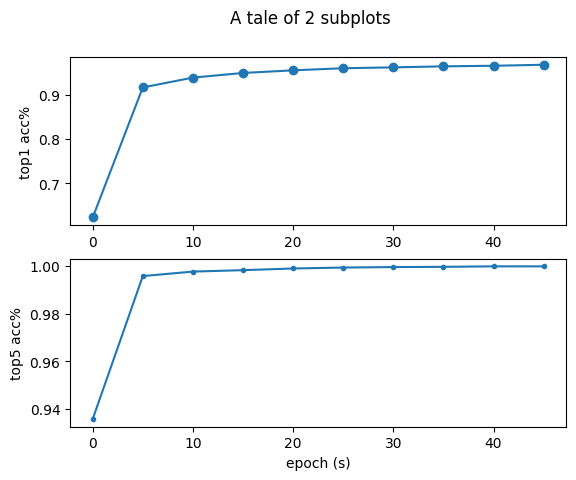

In [ ]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon, np
from mxnet.gluon.data.vision import transforms
from gluoncv.data import transforms as gcv_transforms
import numpy as np
import time, random, argparse, itertools
import math
import matplotlib.pyplot as plt
np.warnings.filterwarnings('ignore')

import sys
# rint(' '.join(sys.argv))


gpu = 0 
nepochs = 50
lr = 0.01
batch_size = 256 
nworkers = 50
nbyz = 15
byz_type = 'gaussian-attack' # or "bitflip_attack" 
interval = 5
aggregation = "median" #"krum" or "parsgd" or "mean"
list1 = []
list2 = []
zeno_batch_size=4
rho_ratio = 0.1
b = 10



# no faulty workers
def no_byz(v, f):
    pass

# failures that add Gaussian noise
def gaussian_attack(v, f):
    for i in range(f):
        v[i] = mx.nd.random.normal(0, 200, shape=v[i].shape)

# bit-flipping failure
def bitflip_attack(v, f):
    for i in range(f):
        if i > 0:
            v[i][:] = -v[0]
    v[0][:] = -v[0]

def ddos(v, f):
    time.sleep(1000)



def no_byz(v, f):
    pass

def median(gradients, net, lr, f = 0, byz = no_byz):
    # X is a 2d list of nd array
    # TODO: improve the implementation of median, the current one is very slow
    param_list = [nd.concat(*[xx.reshape((-1, 1)) for xx in x], dim=0) for x in gradients]
    byz(param_list, f)
    sorted_array = nd.sort(nd.concat(*param_list, dim=1), axis=-1)
    if sorted_array.shape[-1] % 2 == 1:
        median_nd = sorted_array[:, int(sorted_array.shape[-1]/2)]
    else:
        median_nd = (sorted_array[:, int(sorted_array.shape[-1]/2-1)] + sorted_array[:, int(sorted_array.shape[-1]/2)]) / 2.

    idx = 0
    for j, (param) in enumerate(net.collect_params().values()):
        if param.grad_req != 'null':
            # mapping back to the collection of ndarray
            param.set_data(param.data() - lr * median_nd[idx:(idx+param.data().size)].reshape(param.data().shape))
            idx += param.data().size

def score(gradient, v, f):
    if 2*f+2 > v.shape[1]:
        f = int(math.floor((v.shape[1]-2)/2.0))
    num_neighbours = v.shape[1] - 2 - f
    sorted_distance = nd.square(v - gradient).sum(axis=0).sort()
    return nd.sum(sorted_distance[1:(1+num_neighbours)]).asscalar()
  

def krum(gradients, net, lr, f = 0, byz = no_byz):
    # X is a 2d list of nd array
    param_list = [nd.concat(*[xx.reshape((-1, 1)) for xx in x], dim=0) for x in gradients]

    byz(param_list, f)
    v = nd.concat(*param_list, dim=1)
    scores = nd.array([score(gradient, v, f) for gradient in param_list])

    min_idx = int(scores.argmin(axis=0).asscalar())
    krum_nd = nd.reshape(param_list[min_idx], shape=(-1,))
    idx = 0
    for j, (param) in enumerate(net.collect_params().values()):
        if param.grad_req != 'null':
            # mapping back to the collection of ndarray
            param.set_data(param.data() - lr * krum_nd[idx:(idx+param.data().size)].reshape(param.data().shape))
            idx += param.data().size


def minx(gradients, net, lr, f = 0, byz = no_byz):
    # X is a 2d list of nd array
    param_list = [nd.concat(*[xx.reshape((-1, 1)) for xx in x], dim=0) for x in gradients]

    byz(param_list, f)
    sorted_array = nd.sort(nd.concat(*param_list, dim=1), axis=-1)
    
    indices = nd.argsort(sorted_array, axis=-1, dtype='int32')[:,:1]
    krum_nd = np.take_along_axis(sorted_array, indices, axis = 1)
    print(sorted_array)
    idx = 0
    for j, (param) in enumerate(net.collect_params().values()):
        if param.grad_req != 'null':
            # mapping back to the collection of ndarray
            param.set_data(param.data() - lr * krum_nd[idx:(idx+param.data().size)].reshape(param.data().shape))
            idx += param.data().size


def zeno(gradients, net, loss_fun, lr, sample, rho_ratio, b, f = 0, byz = no_byz):
    # X is a 2d list of nd array
    param_list = [nd.concat(*[xx.reshape((-1, 1)) for xx in x], dim=0) for x in gradients]

    param_net = [xx.data().copy() for xx in net.collect_params().values()]

    byz(param_list, f)
    output = net(sample[0])
    loss_1_nd = loss_fun(output, sample[1])
    loss_1 = nd.mean(loss_1_nd).asscalar()
    scores = []
    rho = lr / rho_ratio
    for i in range(len(param_list)):
        idx = 0
        for j, param in enumerate(net.collect_params().values()):
            if param.grad_req != 'null':
                param.set_data(param_net[j] - lr * param_list[i][idx:(idx+param.data().size)].reshape(param.data().shape))
                idx += param.data().size
        output = net(sample[0])
        loss_2_nd = loss_fun(output, sample[1])
        loss_2 = nd.mean(loss_2_nd).asscalar()
        scores.append(loss_1 - loss_2 - rho * param_list[i].square().mean().asscalar())
    scores_np = np.array(scores)
    scores_idx = np.argsort(scores_np)
    scores_idx = scores_idx[-(len(param_list)-b):].tolist()
    g_aggregated = nd.zeros_like(param_list[0])
    for idx in scores_idx:
        g_aggregated += param_list[idx]
    g_aggregated /= float(len(scores_idx))
    
    idx = 0
    for j, (param) in enumerate(net.collect_params().values()):
        if param.grad_req != 'null':
            # mapping back to the collection of ndarray
            param.set_data(param_net[j] - lr * g_aggregated[idx:(idx+param.data().size)].reshape(param.data().shape))
            idx += param.data().size



def NormSInv(p):  
    a1 = -39.6968302866538
    a2 = 220.946098424521
    a3 = -275.928510446969
    a4 = 138.357751867269
    a5 = -30.6647980661472 
    a6 = 2.50662827745924
    b1 = -54.4760987982241 
    b2 = 161.585836858041
    b3 = -155.698979859887
    b4 = 66.8013118877197
    b5 = -13.2806815528857
    c1 = -7.78489400243029E-03
    c2 = -0.322396458041136 
    c3 = -2.40075827716184
    c4 = -2.54973253934373
    c5 = 4.37466414146497 
    c6 = 2.93816398269878
    d1 = 7.78469570904146E-03
    d2 = 0.32246712907004
    d3 = 2.445134137143
    d4 = 3.75440866190742
    p_low = 0.02425
    p_high = 1 - p_low


    if ((p < 0) or (p > 1)): 
        # print("NormSInv: Argument out of range.")
        retVal = 0
    elif (p < p_low): 
        q = math.sqrt(-2 * math.log(p))
        retVal = (((((c1 * q + c2) * q + c3) * q + c4) * q + c5) * q + c6) / ((((d1 * q + d2) * q + d3) * q + d4) * q + 1)
    elif (p <= p_high):
        q = p - 0.5
        r = q * q
        retVal = (((((a1 * r + a2) * r + a3) * r + a4) * r + a5) * r + a6) * q / (((((b1 * r + b2) * r + b3) * r + b4) * r + b5) * r + 1)
    else: 
        q = math.sqrt(-2 * math.log(1 - p));
        retVal = -(((((c1 * q + c2) * q + c3) * q + c4) * q + c5) * q + c6) / ((((d1 * q + d2) * q + d3) * q + d4) * q + 1)

    return retVal

def rnd4(x): 
    if x[0] >= 0.0001 or x[0] < -0.0001:
        return np.round(x[0]*10000)/10000
    else:
        return 0


def emvr(gradients, net, lr, e, f = 0, byz = no_byz): 

    param_list = [nd.concat(*[xx.reshape((-1, 1)) for xx in x], dim=0) for x in gradients]
    byz(param_list, f)
    
    sg = nd.sort(nd.concat(*param_list, dim=1), axis=-1) 
  
    #print(list2[1].size)

    if sg.shape[-1] % 2 == 1: 
        med = sg[:, int(sg.shape[-1]/2)]
    else:
        med = (sg[:, int(sg.shape[-1]/2-1)] + sg[:, int(sg.shape[-1]/2)]) / 2.

    portion2trim = int(nworkers*0.25) # 0.25 for head and tail
    
    trim_sg = sg[:, portion2trim:-portion2trim]


    tsg_mean = nd.mean(trim_sg, axis=-1)
    ind1quar = (nworkers - 2*portion2trim)//4
    ind3quar = ind1quar*3
    
    #"mean and std estimate"
    w = 0.70+0.39/nworkers
    q1, q3 = trim_sg[:, int(ind1quar-1)], trim_sg[:, int(ind3quar-1)]
    lens = q3 - q1 # shape of M
    mean_est = w*(q1+q3)/2 + (1-w)*med #mean from math
    std_est = lens/(2*NormSInv((0.75*nworkers-0.125)/(nworkers+0.25))) #std from math

    #"get results"
    diff = nd.abs(mean_est - tsg_mean) # shape of M
    threshold = 1*std_est # shape of M
    
    res = nd.sum(diff<threshold) # err rate =  400 / 1322000 = 0.0003   diff < threshold
    res = res.squeeze().asnumpy()
    print("$$$$$$$$ epoch = %d, res rate = %f" % (e, res/len(diff)))
    list1.append(res/len(diff))

    idx = 0 
    for j, (param) in enumerate(net.collect_params().values()):
        if param.grad_req != 'null':
            param.set_data(param.data() - lr * mean_est[idx:(idx+param.data().size)].reshape(param.data().shape))
            idx += param.data().size

ctx = mx.gpu(gpu)


with mx.gpu(gpu):
    classes = 100

    net = gluon.nn.Sequential()
    with net.name_scope():
        #  First convolutional layer
        net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, padding=(1,1), activation='relu'))
        net.add(gluon.nn.BatchNorm())
        net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, padding=(1,1), activation='relu'))
        net.add(gluon.nn.BatchNorm())
        net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
        net.add(gluon.nn.Dropout(rate=0.25))
        net.add(gluon.nn.Conv2D(channels=128, kernel_size=3, padding=(1,1), activation='relu'))
        net.add(gluon.nn.BatchNorm())
        net.add(gluon.nn.Conv2D(channels=128, kernel_size=3, padding=(1,1), activation='relu'))
        net.add(gluon.nn.BatchNorm())
        net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
        net.add(gluon.nn.Dropout(rate=0.25))
        net.add(gluon.nn.Flatten())
      
        net.add(gluon.nn.Dense(128, activation="relu"))
       
        net.add(gluon.nn.Dropout(rate=0.25))
        net.add(gluon.nn.Dense(classes))


    # byzantine
    if byz_type == 'label':
        byz = no_byz
    else:
        if byz_type == 'bitflip':
            byz = bitflip_attack
        elif byz_type == "gaussian-attack":
            byz = gaussian_attack
        else:
            byz = no_byz
    shuffle_data = False

    def transform(data, label):
        data = np.transpose(data, (2,0,1))
        data = data.astype(np.float32) / 255
        return data, label

    acc_top1 = mx.metric.Accuracy()
    acc_top5 = mx.metric.TopKAccuracy(5)
    train_cross_entropy = mx.metric.CrossEntropy()

  
    train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST('./data/cx2', train=True, transform=transform),
                                batch_size, shuffle=shuffle_data, last_batch='discard')
    val_train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST('./data/cx2', train=True, transform=transform),
                                batch_size, shuffle=False, last_batch='keep')
    val_test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST('./data/cx2', train=False, transform=transform),
                                batch_size, shuffle=False, last_batch='keep')
    zeno_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST('/data/cx2', train=True, transform=transform),
                                    zeno_batch_size, shuffle=True, last_batch='rollover')
    zeno_iter = itertools.cycle(zeno_data)
    # initialization
    net.initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)

    # loss function
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

    num_workers = nworkers
    lr = lr / batch_size

    epochs = nepochs
    itr = 0
    grad_list = []
    worker_idx = 0
    time_0 = time.time()


    x_list = []
    y_list = []
    y2_list = []
    loss1 = []
    

    for e in range(epochs):
        tic = time.time()

        for i, (data, label) in enumerate(train_data):
            if byz_type == 'label' and worker_idx < nbyz: 
                label = 9 - label
            with autograd.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
            loss.backward()


            grad_collect = []

            for param in net.collect_params().values():
                if param.grad_req != 'null':
                    grad_collect.append(param.grad().copy())

            grad_list.append(grad_collect)

            itr += 1
            worker_idx += 1
           
            if itr % num_workers == 0:
                worker_idx = 0
                if aggregation == "emvr":
                    emvr(grad_list, net, lr, e, nbyz, byz)
                elif aggregation == "median":
                    emvr(grad_list, net, lr, e, nbyz, byz)
                elif aggregation == "krum":
                    emvr(grad_list, net, lr, e, nbyz, byz)
                elif aggregation == 'zeno':
                    zeno_sample = next(zeno_iter)
                    zeno(grad_list, net, softmax_cross_entropy, lr, zeno_sample, rho_ratio, b, nbyz, byz)
                del grad_list
                grad_list = []
        toc = time.time()

        
        if e % interval == 0 :
            acc_top1.reset()
            acc_top5.reset()
            train_cross_entropy.reset()
            #accuracy on testing data
            for i, (data, label) in enumerate(val_test_data):
                outputs = net(data)
                acc_top1.update(label, outputs)
                acc_top5.update(label, outputs)
            # cross entropy on training data
            for i, (data, label) in enumerate(val_train_data):
                outputs = net(data)
                train_cross_entropy.update(label, nd.softmax(outputs))

            _, top1 = acc_top1.get()
            _, top5 = acc_top5.get()
            _, crossentropy = train_cross_entropy.get()

  
            x_list.append(e)
            y_list.append(top1)
            y2_list.append(top5)
            loss1.append(crossentropy)
        
    
    print(x_list)
    print(y_list)
    print(y2_list)
    print(loss1)
    

    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle('A tale of 2 subplots')
    ax1.plot(x_list, y_list, 'o-')
    ax1.set_ylabel('top1 acc%')
    ax2.plot(x_list, y2_list, '.-')
    ax2.set_xlabel('epoch (s)')
    ax2.set_ylabel('top5 acc%')
    plt.show()
